In [51]:
"""
Source Code for Homework 3.a of ECBM E6040, Spring 2016, Columbia University

Instructor: Prof. Aurel A. Lazar

This code is based on
[1] http://deeplearning.net/tutorial/logreg.html
[2] http://deeplearning.net/tutorial/mlp.html
[3] http://deeplearning.net/tutorial/lenet.html
"""

%matplotlib inline

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy
import pickle
import theano
from theano import function
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

from hw3_utils import shared_dataset, load_data
from hw3_nn import LogisticRegression, HiddenLayer, myMLP, LeNetConvPoolLayer, train_nn


# TODO
def input_noise_injection(array, array_shape, noise_type, rng):
    # (13186, 3072)
    # (13186,)
    # (65930, 3072)
    # (65930,)
    if noise_type == 'normal':
        rv = rng.normal(scale=0.01, size=array_shape)
    elif noise_type == 'uniform':
        rv = rng.uniform(low=-0.5, high=0.5, size=array_shape)
    # rv = rv.astype('float32')
    # print array., rv.dtype
    # print array_shape, rv.shape
    output = array + rv.astype('float32')
    print output.shape.eval()
    return output 

def weight_noise_injection(array_shape, noise_type, scale, rng):
    # (13186, 3072)
    # (13186,)
    # (65930, 3072)
    # (65930,)
    noise = []
    
    for i in range(len(array_shape)):
#         print array_shape[i]
        if i % 2 == 0: # and i <= len(array_shape) - 3:
            if noise_type == 'normal':
                rv = rng.normal(std=scale, size=(array_shape[i][0], array_shape[i][1]))
#                 print rv.shape.eval()
                noise.append(rv)
            elif noise_type == 'uniform':
                rv = rng.uniform(low=-scale, high=scale, size=(array_shape[i][0], array_shape[i][1]))
#                 print rv.shape.eval()
                noise.append(rv)
        else:
            rv = numpy.zeros(array_shape[i])
#             print '0', rv.shape
            noise.append(rv.astype('float32'))
    return noise
        
# TODO
def translate_image(array, direction, size):
    if direction == 'up':
        # Remove last 32 * 3 numbers and pad the end with 0s
        return numpy.hstack((array[:, :array.shape[1] - (size * 3)], numpy.zeros((array.shape[0], size * 3))))
    elif direction == 'down':
        # Remove first 32 * 3 numbers and pad the start with 0s
        return numpy.hstack((numpy.zeros((array.shape[0], size * 3)), array[:, size * 3:]))
    elif direction == 'left':
        # Remove for 0 to 31, the first three numbers of each row and add three numbers to the end of each row
        for i in range(size):
            return numpy.hstack((array[:, (i + 1) * size - (size - 3):(i + 1) * size], numpy.zeros((array.shape[0], 3))))
    elif direction == 'right':
        # Reverse of left
        for i in range(size):
            return numpy.hstack((numpy.zeros((array.shape[0], 3)), array[:, i * size:(i + 1) * size - 3]))

# TODO
def test_noise_inject_at_weight(learning_rate=0.01,
             L1_reg=0.00, L2_reg=0.0001, n_epochs=100,
             batch_size=128, n_hidden=500, n_hiddenLayers=3, scale=0.001,
             verbose=False, noise_type='normal'):
    """
    Wrapper function for experiment of noise injection at weights

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient.

    :type L1_reg: float
    :param L1_reg: L1-norm's weight when added to the cost (see
    regularization).

    :type L2_reg: float
    :param L2_reg: L2-norm's weight when added to the cost (see
    regularization).

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer.

    :type batch_size: int
    :param batch_szie: number of examples in minibatch.

    :type n_hidden: int or list of ints
    :param n_hidden: number of hidden units. If a list, it specifies the
    number of units in each hidden layers, and its length should equal to
    n_hiddenLayers.

    :type n_hiddenLayers: int
    :param n_hiddenLayers: number of hidden layers.

    :type verbose: boolean
    :param verbose: to print out epoch summary or not to.

    :type smaller_set: boolean
    :param smaller_set: to use the smaller dataset or not to.

    """
    rng = numpy.random.RandomState(23455)

    # Load down-sampled dataset in raw format (numpy.darray, not Theano.shared)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a numpy.ndarray of 2 dimensions (a matrix), where each row
    # corresponds to an example. target is a numpy.ndarray of 1 dimension
    # (vector) that has the same length as the number of rows in the input.

    # Load the smaller dataset
    datasets = load_data(ds_rate=5)

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
    n_train_batches //= batch_size
    n_valid_batches //= batch_size
    n_test_batches //= batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch

    x = T.matrix('x')   # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(1234)

    classifier = myMLP(
        rng=rng,
        input=x,
        n_in=32*32*3,
        n_hidden=n_hidden,
        n_hiddenLayers=n_hiddenLayers,
        n_out=10
    )

    # the cost we minimize during training is the negative log likelihood of
    # the model plus the regularization terms (L1 and L2); cost is expressed
    # here symbolically
    cost = (
        classifier.negative_log_likelihood(y)
        + L1_reg * classifier.L1
        + L2_reg * classifier.L2_sqr
    )

    # compiling a Theano function that computes the mistakes that are made
    # by the model on a minibatch
    test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index * batch_size:(index + 1) * batch_size],
            y: test_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    # compute the gradient of cost with respect to theta (sorted in params)
    # the resulting gradients will be stored in a list gparams
    gparams = [T.grad(cost, param) for param in classifier.params]

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs

    # given two lists of the same length, A = [a1, a2, a3, a4] and
    # B = [b1, b2, b3, b4], zip generates a list C of same size, where each
    # element is a pair formed from the two lists :
    #    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]

    # TODO: modify updates to inject noise to the weight
    # Reminder: self.params = [self.W, self.b]
#     print [param for param in classifier.params]
#     print [param.shape.eval() for param in classifier.params]
#     print len(classifier.params)
    
    srng = RandomStreams(seed=234)
    
    updates = [
        (param, param - learning_rate * gparam + noise)
        for param, gparam, noise in zip(classifier.params, gparams, weight_noise_injection([param.shape.eval() for param in classifier.params], noise_type, scale, srng))
    ]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')

    train_nn(train_model, validate_model, test_model,
        n_train_batches, n_valid_batches, n_test_batches, n_epochs, verbose)
    
def test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=100,
             batch_size=128, n_hidden=500, n_hiddenLayers=3,
             verbose=False, smaller_set=True):
    """
    Wrapper function for training and testing MLP

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient.

    :type L1_reg: float
    :param L1_reg: L1-norm's weight when added to the cost (see
    regularization).

    :type L2_reg: float
    :param L2_reg: L2-norm's weight when added to the cost (see
    regularization).

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer.

    :type batch_size: int
    :param batch_szie: number of examples in minibatch.

    :type n_hidden: int or list of ints
    :param n_hidden: number of hidden units. If a list, it specifies the
    number of units in each hidden layers, and its length should equal to
    n_hiddenLayers.

    :type n_hiddenLayers: int
    :param n_hiddenLayers: number of hidden layers.

    :type verbose: boolean
    :param verbose: to print out epoch summary or not to.

    :type smaller_set: boolean
    :param smaller_set: to use the smaller dataset or not to.

    """
    # load the dataset; download the dataset if it is not present
    if smaller_set:
        datasets = load_data(ds_rate=5)
    else:
        datasets = load_data()

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(1234)

    # TODO: construct a neural network, either MLP or CNN.
    classifier = myMLP(
       rng=rng,
       input=x,
       n_in=32*32*3,
       n_hidden=n_hidden,
       n_out=10,
       n_hiddenLayers=n_hiddenLayers
    )

    # the cost we minimize during training is the negative log likelihood of
    # the model plus the regularization terms (L1 and L2); cost is expressed
    # here symbolically
    cost = (
        classifier.negative_log_likelihood(y)
        + L1_reg * classifier.L1
        + L2_reg * classifier.L2_sqr
    )

    # compiling a Theano function that computes the mistakes that are made
    # by the model on a minibatch
    test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index * batch_size:(index + 1) * batch_size],
            y: test_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    # compute the gradient of cost with respect to theta (sotred in params)
    # the resulting gradients will be stored in a list gparams
    gparams = [T.grad(cost, param) for param in classifier.params]

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs

    # given two lists of the same length, A = [a1, a2, a3, a4] and
    # B = [b1, b2, b3, b4], zip generates a list C of same size, where each
    # element is a pair formed from the two lists :
    #    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')

    train_nn(train_model, validate_model, test_model,
        n_train_batches, n_valid_batches, n_test_batches, n_epochs, verbose)

#     with open('list_weight', 'w') as F:
#         pickle.dump([numpy.array(p.eval()) for p in classifier.params], F)
        
    g_adv = T.grad(cost, classifier.input)
    
    gradient = theano.function(
        inputs=[x, y],
        outputs=g_adv
    )
    
    '''
    gradient = theano.function(
            inputs=[index],
            outputs=g_adv,
            givens={
                x: train_set_x[index:index+1],
                y: train_set_y[index:index+1]
            }
    )
    '''
    
#     print test_set_x.shape.eval(), test_set_x[0,:].shape.eval()

    
#     print test_set_y[0].eval(), train_set_y[0].eval()
#     print train_set_x[0:1].shape.eval()
    
    # Reverse engineer from utils
    img = test_set_x[0,:].eval().reshape((3, 32, 32)).transpose(1,2,0)
    
    img_add = train_set_x[0,:].eval().reshape((3, 32, 32)).transpose(1,2,0)
    
    g = gradient(train_set_x[0:1].eval(), train_set_y[0:1].eval())
    
    img_grad = g.reshape((3, 32, 32)).transpose(1,2,0)
    
    test_set_x_adv = test_set_x[0,:] + 0.05 * g
    
    test_set_x_adv = test_set_x_adv.reshape(g.shape)
    
    img_adv = test_set_x_adv.eval().reshape((3, 32, 32)).transpose(1,2,0)

    '''
    Working
    img = test_set_x[0,:].eval().reshape((3, 32, 32)).transpose(1,2,0)
        
    img_add = train_set_x[0,:].eval().reshape((3, 32, 32)).transpose(1,2,0)
        
    img_grad = gradient(0).reshape((3, 32, 32)).transpose(1,2,0)
        
    test_set_x_adv = test_set_x[0,:] + 0.05 * gradient(0).reshape(-1,)
        
    test_set_x_adv = test_set_x_adv.reshape(gradient(0).shape)
        
    img_adv = test_set_x_adv.eval().reshape((3, 32, 32)).transpose(1,2,0)
    '''
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1,4,1)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title('Adversarial Image')
    plt.axis('off')
    plt.imshow(img_adv)
    plt.subplot(1,4,3)
    plt.title('Added Image')
    plt.axis('off')
    plt.imshow(img_add)
    plt.subplot(1,4,4)
    plt.title('Image Gradient')
    plt.axis('off')
    plt.imshow(img_grad)
    plt.tight_layout()
    
#     print test_set_x_adv.shape.eval()

    '''
    predict_adv = theano.function(
        inputs=[index],
        outputs=classifier.predictions(index),
        givens={
            x: test_set_x_adv[index:index+1]
        }
    )
    
    predict_norm = theano.function(
        inputs=[index],
        outputs=classifier.predictions(index),
        givens={
            x: test_set_x[index:index+1]
        }
    )
    '''
    
    predict = theano.function(
        inputs=[x],
        outputs=classifier.predictions()
    )
    
    
    test_model_adv = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x_adv[index:index+1],
            y: test_set_y[index:index+1]
        }
    )
    
    test_model_norm = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index:index+1],
            y: test_set_y[index:index+1]
        }
    )
    
#     print test_set_x[0:1].eval().shape
#     print predict(test_set_x_adv.eval())
    
    x = [0,1,2,3,4,5,6,7,8,9]
    plt.figure(figsize=(8, 6))
    plt.subplot(1,2,1)
    plt.bar(x, predict(test_set_x[0:1].eval())[0])
    plt.title('Original Predicted Probabilities')
    plt.subplot(1,2,2)
    plt.bar(x, predict(test_set_x_adv.eval())[0])
    plt.title('Adversarial Predicted Probabilities')
    plt.tight_layout()
    plt.show()
    
#     print predict_norm(0), predict_adv(0)
#     print test_model_norm(0), test_model_adv(0)
    

... building the model
... training
training @ iter =  0
training @ iter =  100
epoch 1, minibatch 103/103, validation error 81.392045 %
     epoch 1, minibatch 103/103, test error of best model 80.414871 %
training @ iter =  200
epoch 2, minibatch 103/103, validation error 81.392045 %
training @ iter =  300
epoch 3, minibatch 103/103, validation error 81.392045 %
training @ iter =  400
epoch 4, minibatch 103/103, validation error 81.392045 %
training @ iter =  500
epoch 5, minibatch 103/103, validation error 81.392045 %
training @ iter =  600
epoch 6, minibatch 103/103, validation error 81.392045 %
training @ iter =  700
epoch 7, minibatch 103/103, validation error 81.392045 %
training @ iter =  800
epoch 8, minibatch 103/103, validation error 81.392045 %
training @ iter =  900
epoch 9, minibatch 103/103, validation error 81.534091 %
training @ iter =  1000
epoch 10, minibatch 103/103, validation error 81.250000 %
     epoch 10, minibatch 103/103, test error of best model 80.226293 %


The training process for function test_mlp ran for 1.49m


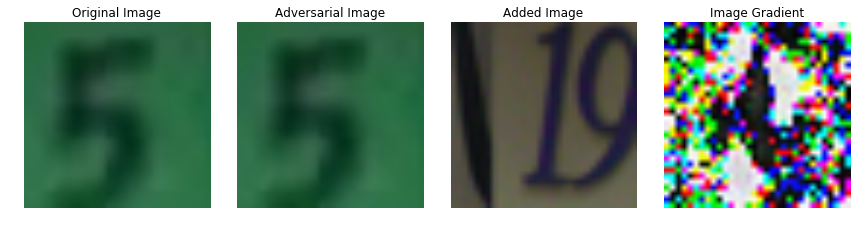

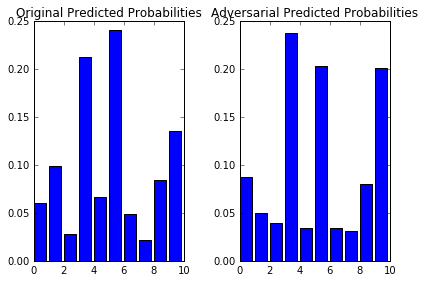

In [52]:
test_mlp(learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, n_epochs=100,
             batch_size=128, n_hidden=500, n_hiddenLayers=3,
             verbose=True, smaller_set=True)

In [6]:
test_noise_inject_at_weight(learning_rate=0.01,
             L1_reg=0.00, L2_reg=0.0001, n_epochs=300,
             batch_size=128, n_hidden=500, n_hiddenLayers=3, scale=0.00005,
             verbose=True, noise_type='normal')

... building the model
[3072  500]
[3072  500]
[500]
0 (500,)
[500 500]
[500 500]
[500]
0 (500,)
[500 500]
[500 500]
[500]
0 (500,)
[500  10]
[500  10]
[10]
0 (10,)
... training
training @ iter =  0
training @ iter =  100
epoch 1, minibatch 103/103, validation error 81.392045 %
     epoch 1, minibatch 103/103, test error of best model 80.414871 %
training @ iter =  200
epoch 2, minibatch 103/103, validation error 81.392045 %
training @ iter =  300
epoch 3, minibatch 103/103, validation error 81.392045 %
training @ iter =  400
epoch 4, minibatch 103/103, validation error 81.392045 %
training @ iter =  500
epoch 5, minibatch 103/103, validation error 81.392045 %
training @ iter =  600
epoch 6, minibatch 103/103, validation error 81.392045 %
training @ iter =  700
epoch 7, minibatch 103/103, validation error 81.463068 %
training @ iter =  800
epoch 8, minibatch 103/103, validation error 81.392045 %
training @ iter =  900
epoch 9, minibatch 103/103, validation error 81.463068 %
training @ 

The training process for function test_noise_inject_at_weight ran for 5.57m


In [ ]:
test_noise_inject_at_weight(learning_rate=0.01,
             L1_reg=0.00, L2_reg=0.0001, n_epochs=300,
             batch_size=128, n_hidden=500, n_hiddenLayers=3, scale=0.00001,
             verbose=True, noise_type='normal')

... building the model
[W, b, W, b, W, b, W, b]
[array([3072,  500]), array([500]), array([500, 500]), array([500]), array([500, 500]), array([500]), array([500,  10]), array([10])]
8
(3072, 500)
0 (500,)
(500, 500)
0 (500,)
(500, 500)
0 (500,)
(500, 10)
0 (10,)
... training
training @ iter =  0
training @ iter =  100
epoch 1, minibatch 103/103, validation error 81.392045 %
     epoch 1, minibatch 103/103, test error of best model 80.414871 %
training @ iter =  200
epoch 2, minibatch 103/103, validation error 81.392045 %
training @ iter =  300
epoch 3, minibatch 103/103, validation error 81.392045 %
training @ iter =  400
epoch 4, minibatch 103/103, validation error 81.392045 %
training @ iter =  500
epoch 5, minibatch 103/103, validation error 81.392045 %
training @ iter =  600
epoch 6, minibatch 103/103, validation error 81.392045 %
training @ iter =  700
epoch 7, minibatch 103/103, validation error 81.392045 %
training @ iter =  800
epoch 8, minibatch 103/103, validation error 81.53

In [1]:
from hw3_utils import shared_dataset, load_data
datasets = load_data(ds_rate=5)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

Using gpu device 0: GRID K520


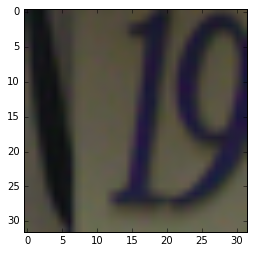

In [5]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
img = test_set_x[0,:].eval().reshape((3, 32, 32)).transpose(1,2,0)
img_add = train_set_x[0,:].eval().reshape((3, 32, 32)).transpose(1,2,0)
plt.imshow(img_add)

In [28]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
print test_set_x.shape.eval()
o_shape = test_set_x.shape.eval()
test_set_x_reshape = test_set_x.transpose(1,0).reshape((3, 32, 32, -1))
shape = test_set_x_reshape.shape.eval()
# print shape
# zeros = numpy.zeros((shape[0], 1, shape[2], shape[3]))
# print zeros.shape
test_set_up = numpy.concatenate((test_set_x_reshape[:, :31, :, :].eval(), numpy.zeros((shape[0], 1, shape[2], shape[3]))), axis=1)
test_set_down = numpy.concatenate((numpy.zeros((shape[0], 1, shape[2], shape[3])), test_set_x_reshape[:, 1:, :, :].eval()), axis=1)
test_set_left = numpy.concatenate((test_set_x_reshape[:, :, :31, :].eval(), numpy.zeros((shape[0], shape[1], 1, shape[3]))), axis=2)
test_set_right = numpy.concatenate((numpy.zeros((shape[0], shape[1], 1, shape[3])), test_set_x_reshape[:, :, 1:, :].eval()), axis=2)

up = test_set_up.reshape(*o_shape).transpose(1,0)
down

print test_set_up.shape
print test_set_down.shape
print test_set_left.shape
print test_set_right.shape

[26032  3072]


NameError: name 'down' is not defined